In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LeakyReLU,
    Activation,
    GlobalAveragePooling2D,
)
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import cv2
import os
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import class_weight
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

Using TensorFlow backend.


In [3]:
sns.set_palette("rainbow")


# Define paths and image size
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
labels = ["PNEUMONIA", "NORMAL"]
img_size = 150

In [4]:
import os
import cv2
import numpy as np
from imblearn.over_sampling import RandomOverSampler

def get_data(data_dir, img_size=150):
    data, target = [], []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append(img_arr)
                target.append(class_num)
            except Exception as e:
                continue
    return np.array(data), np.array(target)

x, y = get_data(os.path.join(data_dir, "train"))
x_test, y_test = get_data(os.path.join(data_dir, "test"))

x = x / 255.0
x_test = x_test / 255.0

# Apply oversampling to balance classes
x_reshaped = x.reshape(x.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
x_resampled, y_resampled = oversampler.fit_resample(x_reshaped, y)
x_resampled = x_resampled.reshape(-1, 150, 150, 3)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))



PNEUMONIA: 3100
NORMAL: 3100


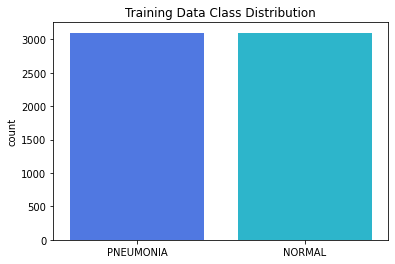

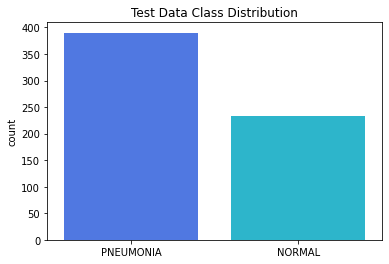

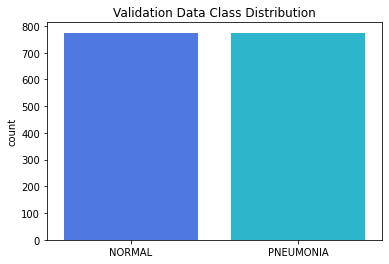

In [5]:
def plot_class_distribution(y_data, title): #changed to accept y_data
    l = [labels[i] for i in y_data]  # Extract labels from y_data
    sns.countplot(x=l)
    plt.title(title)
    plt.show()

# Explicitly print the class counts to confirm the imbalance
pneumonia_count = np.sum(y_train == 0)
normal_count = np.sum(y_train == 1)
print(f"PNEUMONIA: {pneumonia_count}")
print(f"NORMAL: {normal_count}")

# Plot class distributions for train, validation, and test sets
plot_class_distribution(y_train, "Training Data Class Distribution")
plot_class_distribution(y_test, "Test Data Class Distribution")
plot_class_distribution(y_val, "Validation Data Class Distribution")

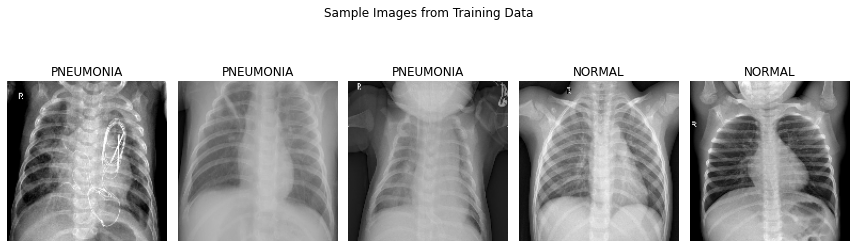

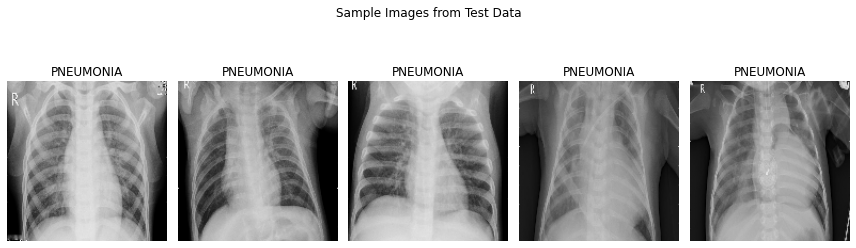

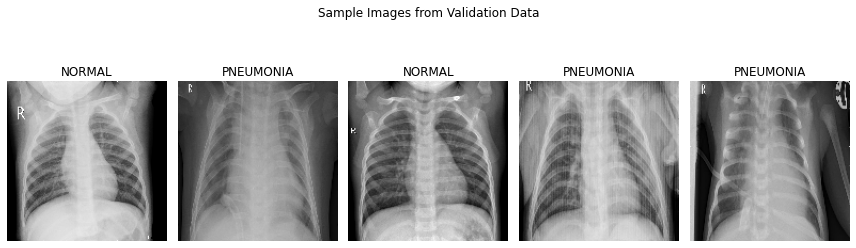

In [6]:
def display_sample_images(x_data, y_data, title, num_samples=5):
    labels = ['PNEUMONIA', 'NORMAL']  # Define label names
    plt.figure(figsize=(12, 4))
    
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.squeeze(x_data[i]), cmap="gray")  # Remove extra dimension
        plt.title(labels[y_data[i]])  # Convert class index to label name
        plt.axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust for title space
    plt.show()

# Now call the function
display_sample_images(x_train, y_train, "Sample Images from Training Data")
display_sample_images(x_test, y_test, "Sample Images from Test Data")
display_sample_images(x_val, y_val, "Sample Images from Validation Data")


In [7]:
x_test[3][3][3]

array([0.2, 0.2, 0.2])

In [8]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    # brightness_range=[0.8, 1.2]
)
datagen.fit(x_train)


In [9]:
pip install efficientnet

Note: you may need to restart the kernel to use updated packages.


In [10]:
import efficientnet.keras as efn


In [11]:

base_model = efn.EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3)
    )

# Freeze base model layers
base_model.trainable = True  # Enable fine-tuning
for layer in base_model.layers[:-20]:  # Freeze first N layers
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )


16809984/16804768 [==============================] - 1s 0us/step


In [12]:
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-5, verbose=1),
    ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)
]

In [13]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/100
194/194 [==============================] - 37s 191ms/step - loss: 0.2673 - accuracy: 0.8856 - auc: 0.8905 - val_loss: 0.4997 - val_accuracy: 0.7419 - val_auc: 0.9501
Epoch 2/100
194/194 [==============================] - 27s 141ms/step - loss: 0.1584 - accuracy: 0.9427 - auc: 0.9567 - val_loss: 1.1040 - val_accuracy: 0.5781 - val_auc: 0.9568
Epoch 3/100
194/194 [==============================] - 27s 141ms/step - loss: 0.1267 - accuracy: 0.9532 - auc: 0.9573 - val_loss: 1.2140 - val_accuracy: 0.5439 - val_auc: 0.9584
Epoch 4/100
194/194 [==============================] - 28s 142ms/step - loss: 0.1176 - accuracy: 0.9594 - auc: 0.9595 - val_loss: 0.7460 - val_accuracy: 0.6445 - val_auc: 0.9621

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/100
194/194 [==============================] - 27s 142ms/step - loss: 0.1052 - accuracy: 0.9632 - auc: 0.9643 - val_loss: 0.3650 - val_accuracy: 0.8155 - val_auc: 0.9670
Epoch 6/100
194/194 [========

In [14]:
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4%}, Test AUC: {test_auc:.4f}")


624/624 [==============================] - 1s 2ms/step
Test Loss: 0.8418, Test Accuracy: 74.0385%, Test AUC: 0.9913


In [15]:
import numpy as np
print("Train class distribution:", np.bincount(y_train))
print("Validation class distribution:", np.bincount(y_val))
print("Test class distribution:", np.bincount(y_test))


Train class distribution: [3100 3100]
Validation class distribution: [775 775]
Test class distribution: [390 234]


In [16]:
model.save("pneumonia_model.h5")  # Save in .h5 format

In [17]:

# batch_size = 32

# history = model.fit(
#     datagen.flow(x_train, y_train, batch_size=batch_size),
#     epochs=20,
#     validation_data=(x_val, y_val),
    
#     class_weight=class_weights,
#     verbose=1
# )

In [18]:
# print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
# print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

In [19]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [20]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.71      0.99      0.83       390
   Normal (Class 1)       0.97      0.32      0.48       234

           accuracy                           0.74       624
          macro avg       0.84      0.66      0.65       624
       weighted avg       0.81      0.74      0.70       624



In [21]:
cm = confusion_matrix(y_test,predictions)
cm

array([[388,   2],
       [160,  74]])

In [22]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

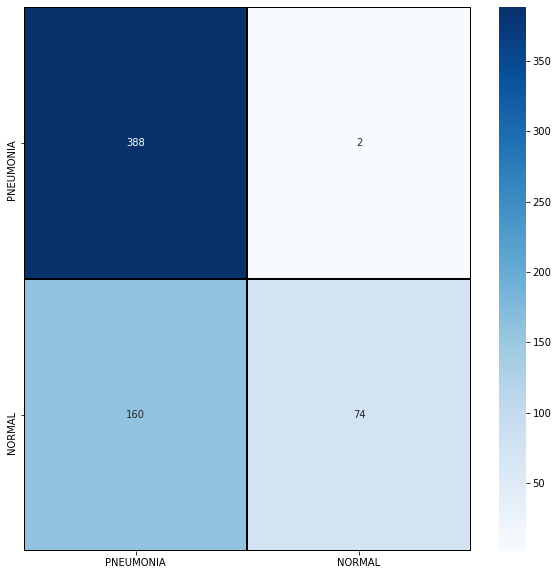

In [23]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [24]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

ValueError: cannot reshape array of size 67500 into shape (150,150)

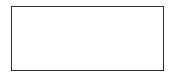

In [25]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1